In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지
# [-1, 1]의 범위로 정규화된 Tensor로 변환
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # (X-mean) / std

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
Epoch = 50

In [ ]:
#이미지 확인하기
def imshow(img):
    img = img / 2 + 0.5     # 정규화 해제
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # width, height, depth (channel)
    # plt.show()

frog


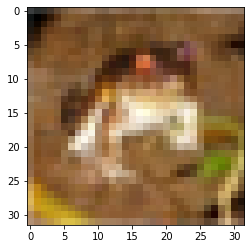

In [ ]:
# 학습용 이미지 뽑기
dataiter = iter(trainset)
images, labels = next(dataiter)

# 이미지 보여주기 (여러개의 이미지를 합쳐서 하나의 grid로 만들어줌)
imshow(torchvision.utils.make_grid(images))

# 이미지별 라벨 (클래스) 보여주기
print(classes[labels])

torch.Size([128, 3, 32, 32]) torch.Size([128])

plane car deer frog


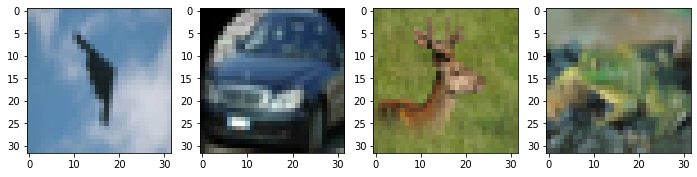

In [ ]:
# 샘플 이미지 확인
for x, y in trainloader:
    print(x.shape, y.shape)
    break

num = 4
img = x[:num]
labels = y[:num]

plt.figure(figsize=(15,15))
for i in range(num):
    plt.subplot(1,num+1,i+1)
    imshow(img[i])

print()
print(" ".join(classes[idx] for idx in labels))

In [ ]:
class Teacher_model(nn.Module):
  def __init__(self, num_classes=10):
    super(Teacher_model, self).__init__()

    # input channels = 3
    # output channels = 6
    # kernal size = 5
    self.conv1 = nn.Conv2d(3, 64, 3)
    self.conv2 = nn.Conv2d(64, 128, 3)
    self.conv3 = nn.Conv2d(128, 256, 3)
    self.conv4 = nn.Conv2d(256, 512, 3)
    # kernal = 2, stride = 2, padding = 0 (default)
    self.pool = nn.MaxPool2d(2, 2)
    #input feature, output feature
    self.fc1 = nn.Linear(512 * 2 * 2, 256)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, num_classes)

    self.dropout = nn.Dropout(0.3)

  # 값 계산
  def forward(self, x):
    # BatchNorm 생략
    x = self.dropout(F.relu(self.conv1(x)))
    x = self.dropout(F.relu(self.conv2(x)))
    x = self.pool(x)
    x = self.dropout(F.relu(self.conv3(x)))
    x = self.pool(x)
    x = self.dropout(F.relu(self.conv4(x)))
    x = self.pool(x)
    # FC -> GAP
    x = x.view(-1, 512 * 2 * 2)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.fc3(x)

    return x

In [ ]:
summary(Teacher_model().to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
           Dropout-2           [-1, 64, 30, 30]               0
            Conv2d-3          [-1, 128, 28, 28]          73,856
           Dropout-4          [-1, 128, 28, 28]               0
         MaxPool2d-5          [-1, 128, 14, 14]               0
            Conv2d-6          [-1, 256, 12, 12]         295,168
           Dropout-7          [-1, 256, 12, 12]               0
         MaxPool2d-8            [-1, 256, 6, 6]               0
            Conv2d-9            [-1, 512, 4, 4]       1,180,160
          Dropout-10            [-1, 512, 4, 4]               0
        MaxPool2d-11            [-1, 512, 2, 2]               0
           Linear-12                  [-1, 256]         524,544
          Dropout-13                  [-1, 256]               0
           Linear-14                   

In [ ]:
teacher_model = Teacher_model().to(device)

In [ ]:
def Model(model, input_data, labels, model_optimizer, criterion):
  
  # Gradient 값이 누적되지 않게 하기 위해 (기울기=0)
  model_optimizer.zero_grad()

  loss = 0
  epoch_loss = 0
  # 출력 계산
  output = model(input_data)
  # 손실 계산
  loss = criterion(output, labels)
  # backpropagation 계산
  loss.backward()
  # model update
  model_optimizer.step()

  epoch_loss = loss.item()

  return epoch_loss

In [ ]:
def TrainModel(model, train_data, epoch=1000):
  
  loss_list = []

  optimizer = optim.Adam(model.parameters(), lr=0.001) # SGD, momentum=0.9
  criterion = nn.CrossEntropyLoss()

  model.train()
  
  for iter in range(epoch):
    loss = 0
    for data in tqdm(train_data):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      loss += Model(model, inputs, labels, optimizer, criterion)

    if iter%1 == 0:
      print('iteration :%d\ntrain_loss : %.4f' % (iter, loss/len(train_data)))
      loss_list.append(loss/len(train_data))

  return model, loss_list

In [ ]:
# Teacher model training
Model, history = TrainModel(teacher_model, trainloader, epoch=Epoch)

100%|██████████| 391/391 [00:26<00:00, 14.90it/s]


iteration :0
train_loss : 1.7027


100%|██████████| 391/391 [00:20<00:00, 19.41it/s]


iteration :1
train_loss : 1.2342


100%|██████████| 391/391 [00:20<00:00, 18.67it/s]


iteration :2
train_loss : 1.0113


100%|██████████| 391/391 [00:21<00:00, 18.45it/s]


iteration :3
train_loss : 0.8702


100%|██████████| 391/391 [00:20<00:00, 19.47it/s]


iteration :4
train_loss : 0.7856


100%|██████████| 391/391 [00:20<00:00, 19.41it/s]


iteration :5
train_loss : 0.7141


100%|██████████| 391/391 [00:20<00:00, 19.27it/s]


iteration :6
train_loss : 0.6665


100%|██████████| 391/391 [00:20<00:00, 19.35it/s]


iteration :7
train_loss : 0.6204


100%|██████████| 391/391 [00:20<00:00, 19.35it/s]


iteration :8
train_loss : 0.5789


100%|██████████| 391/391 [00:21<00:00, 18.61it/s]


iteration :9
train_loss : 0.5521


100%|██████████| 391/391 [00:20<00:00, 19.03it/s]


iteration :10
train_loss : 0.5244


100%|██████████| 391/391 [00:20<00:00, 19.24it/s]


iteration :11
train_loss : 0.5050


100%|██████████| 391/391 [00:20<00:00, 19.46it/s]


iteration :12
train_loss : 0.4756


100%|██████████| 391/391 [00:24<00:00, 16.18it/s]


iteration :13
train_loss : 0.4579


100%|██████████| 391/391 [00:23<00:00, 16.84it/s]


iteration :14
train_loss : 0.4458


100%|██████████| 391/391 [00:20<00:00, 18.78it/s]


iteration :15
train_loss : 0.4199


100%|██████████| 391/391 [00:21<00:00, 18.26it/s]


iteration :16
train_loss : 0.4115


100%|██████████| 391/391 [00:20<00:00, 19.18it/s]


iteration :17
train_loss : 0.3991


100%|██████████| 391/391 [00:20<00:00, 18.97it/s]


iteration :18
train_loss : 0.3801


100%|██████████| 391/391 [00:20<00:00, 19.39it/s]


iteration :19
train_loss : 0.3743


100%|██████████| 391/391 [00:20<00:00, 19.46it/s]


iteration :20
train_loss : 0.3655


100%|██████████| 391/391 [00:20<00:00, 19.50it/s]


iteration :21
train_loss : 0.3497


100%|██████████| 391/391 [00:20<00:00, 18.82it/s]


iteration :22
train_loss : 0.3476


100%|██████████| 391/391 [00:19<00:00, 19.62it/s]


iteration :23
train_loss : 0.3334


100%|██████████| 391/391 [00:20<00:00, 19.47it/s]


iteration :24
train_loss : 0.3313


100%|██████████| 391/391 [00:20<00:00, 19.45it/s]


iteration :25
train_loss : 0.3259


100%|██████████| 391/391 [00:19<00:00, 19.65it/s]


iteration :26
train_loss : 0.3139


100%|██████████| 391/391 [00:19<00:00, 19.73it/s]


iteration :27
train_loss : 0.3098


100%|██████████| 391/391 [00:19<00:00, 19.60it/s]


iteration :28
train_loss : 0.3131


100%|██████████| 391/391 [00:20<00:00, 18.99it/s]


iteration :29
train_loss : 0.2964


100%|██████████| 391/391 [00:19<00:00, 19.58it/s]


iteration :30
train_loss : 0.2815


100%|██████████| 391/391 [00:19<00:00, 19.58it/s]


iteration :31
train_loss : 0.2819


100%|██████████| 391/391 [00:19<00:00, 19.64it/s]


iteration :32
train_loss : 0.2845


100%|██████████| 391/391 [00:20<00:00, 19.43it/s]


iteration :33
train_loss : 0.2765


100%|██████████| 391/391 [00:20<00:00, 19.51it/s]


iteration :34
train_loss : 0.2648


100%|██████████| 391/391 [00:19<00:00, 19.87it/s]


iteration :35
train_loss : 0.2648


100%|██████████| 391/391 [00:20<00:00, 19.00it/s]


iteration :36
train_loss : 0.2651


100%|██████████| 391/391 [00:20<00:00, 19.54it/s]


iteration :37
train_loss : 0.2564


100%|██████████| 391/391 [00:19<00:00, 19.71it/s]


iteration :38
train_loss : 0.2550


100%|██████████| 391/391 [00:19<00:00, 19.57it/s]


iteration :39
train_loss : 0.2473


100%|██████████| 391/391 [00:20<00:00, 19.38it/s]


iteration :40
train_loss : 0.2401


100%|██████████| 391/391 [00:20<00:00, 19.47it/s]


iteration :41
train_loss : 0.2361


100%|██████████| 391/391 [00:20<00:00, 19.43it/s]


iteration :42
train_loss : 0.2405


100%|██████████| 391/391 [00:20<00:00, 18.80it/s]


iteration :43
train_loss : 0.2335


100%|██████████| 391/391 [00:20<00:00, 19.52it/s]


iteration :44
train_loss : 0.2320


100%|██████████| 391/391 [00:20<00:00, 19.44it/s]


iteration :45
train_loss : 0.2260


100%|██████████| 391/391 [00:20<00:00, 19.45it/s]


iteration :46
train_loss : 0.2293


100%|██████████| 391/391 [00:20<00:00, 19.44it/s]


iteration :47
train_loss : 0.2159


100%|██████████| 391/391 [00:20<00:00, 19.38it/s]


iteration :48
train_loss : 0.2228


100%|██████████| 391/391 [00:20<00:00, 18.83it/s]

iteration :49
train_loss : 0.2147


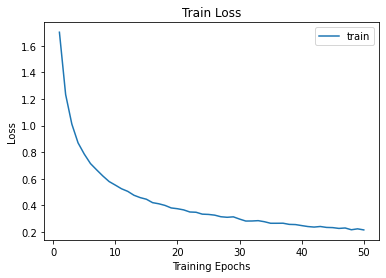

In [ ]:
plt.title('Train Loss')
plt.plot(range(1, Epoch+1), history, label='train')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

In [ ]:
# 학습한 모델 저장
PATH = 'drive/MyDrive/Implementation/'
torch.save(Model.state_dict(), PATH+'model_state_dict.pt') # 파라미터만 저장
torch.save(Model, PATH +'model.pt') # 전체 모델 저장

In [ ]:
# GPU, CPU
# 불러오기 : 방법 2가지
PATH = 'drive/MyDrive/Implementation/'
# 1. 전체 모델을 불러오기

# class Teacher_model(nn.Module):
#   def forward(self, x):
#     pass
# AttributeError: Can't get attribute 'Teacher_model' on <module '__main__'>
# 경고 메세지에서 CustomModel 속성을 가져오지 못했다고 알려주므로 동일한 명칭의 클래스를 생성

t_model = torch.load(PATH +'model.pt') # , map_location=device
t_model.eval()

# 2. 파라미터 불러오기
# th_model = Teacher_model()
# th_model.load_state_dict(torch.load(PATH+'model_state_dict.pt'))
# th_model.eval()

Teacher_model(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

torch.Size([128, 3, 32, 32]) torch.Size([128])

cat ship ship plane


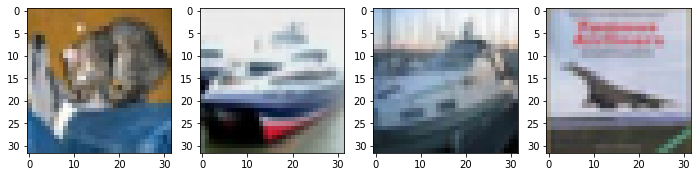

In [ ]:
# 샘플 이미지 확인
for x, y in testloader:
  print(x.shape, y.shape)
  break

num = 4
img = x[:num]
labels = y[:num]

plt.figure(figsize=(15,15))
for i in range(num):
    plt.subplot(1,num+1,i+1)
    imshow(img[i])

print()
print(" ".join(classes[idx] for idx in labels))

In [ ]:
img = img.to(device)
outputs = t_model(img)
_, predicted = torch.max(outputs,1)
print('Predicted:', ' '.join('%s' % classes[predicted[j]] for j in range(4)))

Predicted: cat ship ship plane


In [ ]:
# correct = 0
# total = 0
# # 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         # 신경망에 이미지를 통과시켜 출력을 계산합니다
#         outputs = net(images)
#         # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = t_model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 82 %


In [ ]:
# # 각 분류(class)에 대한 예측값 계산을 위해 준비
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # 변화도는 여전히 필요하지 않습니다
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         outputs = net(images)
#         _, predictions = torch.max(outputs, 1)
#         # 각 분류별로 올바른 예측 수를 모읍니다
#         for label, prediction in zip(labels, predictions):
#             if label == prediction:
#                 correct_pred[classes[label]] += 1
#             total_pred[classes[label]] += 1


# # 각 분류별 정확도(accuracy)를 출력합니다
# for classname, correct_count in correct_pred.items():
#     accuracy = 100 * float(correct_count) / total_pred[classname]
#     print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = t_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 84 %
Accuracy of   car : 91 %
Accuracy of  bird : 69 %
Accuracy of   cat : 70 %
Accuracy of  deer : 84 %
Accuracy of   dog : 73 %
Accuracy of  frog : 88 %
Accuracy of horse : 83 %
Accuracy of  ship : 89 %
Accuracy of truck : 87 %


In [ ]:
class Student_model(nn.Module):
  def __init__(self, num_classes=10):
    super(Student_model, self).__init__()

    # input channels = 3
    # output channels = 6
    # kernal size = 5
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv3 = nn.Conv2d(64, 128, 3)
    self.conv4 = nn.Conv2d(128, 256, 3)
    # kernal = 2, stride = 2, padding = 0 (default)
    self.pool = nn.MaxPool2d(2, 2)
    #input feature, output feature
    self.fc1 = nn.Linear(256 * 2 * 2, 128)
    self.fc2 = nn.Linear(128, 32)
    self.fc3 = nn.Linear(32, num_classes)

    self.dropout = nn.Dropout(0.3)

  # 값 계산
  def forward(self, x):
    # BatchNorm 생략
    x = self.dropout(F.relu(self.conv1(x)))
    x = self.dropout(F.relu(self.conv2(x)))
    x = self.pool(x)
    x = self.dropout(F.relu(self.conv3(x)))
    x = self.pool(x)
    x = self.dropout(F.relu(self.conv4(x)))
    x = self.pool(x)
    # FC -> GAP
    x = x.view(-1, 256 * 2 * 2)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.fc3(x)

    return x

In [ ]:
summary(Student_model().to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
           Dropout-2           [-1, 32, 30, 30]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
           Dropout-4           [-1, 64, 28, 28]               0
         MaxPool2d-5           [-1, 64, 14, 14]               0
            Conv2d-6          [-1, 128, 12, 12]          73,856
           Dropout-7          [-1, 128, 12, 12]               0
         MaxPool2d-8            [-1, 128, 6, 6]               0
            Conv2d-9            [-1, 256, 4, 4]         295,168
          Dropout-10            [-1, 256, 4, 4]               0
        MaxPool2d-11            [-1, 256, 2, 2]               0
           Linear-12                  [-1, 128]         131,200
          Dropout-13                  [-1, 128]               0
           Linear-14                   

In [ ]:
# Student model training from scratch
student_model = Student_model().to(device)
Model_s, history_s = TrainModel(student_model, trainloader, epoch=Epoch)

100%|██████████| 391/391 [00:18<00:00, 20.92it/s]


iteration :0
train_loss : 1.8078


100%|██████████| 391/391 [00:17<00:00, 22.68it/s]


iteration :1
train_loss : 1.4177


100%|██████████| 391/391 [00:16<00:00, 23.32it/s]


iteration :2
train_loss : 1.2340


100%|██████████| 391/391 [00:16<00:00, 23.25it/s]


iteration :3
train_loss : 1.1045


100%|██████████| 391/391 [00:16<00:00, 23.24it/s]


iteration :4
train_loss : 1.0167


100%|██████████| 391/391 [00:16<00:00, 23.29it/s]


iteration :5
train_loss : 0.9368


100%|██████████| 391/391 [00:17<00:00, 22.44it/s]


iteration :6
train_loss : 0.8819


100%|██████████| 391/391 [00:16<00:00, 23.30it/s]


iteration :7
train_loss : 0.8404


100%|██████████| 391/391 [00:17<00:00, 22.00it/s]


iteration :8
train_loss : 0.7999


100%|██████████| 391/391 [00:16<00:00, 23.16it/s]


iteration :9
train_loss : 0.7624


100%|██████████| 391/391 [00:16<00:00, 23.24it/s]


iteration :10
train_loss : 0.7358


100%|██████████| 391/391 [00:16<00:00, 23.08it/s]


iteration :11
train_loss : 0.7009


100%|██████████| 391/391 [00:16<00:00, 23.11it/s]


iteration :12
train_loss : 0.6895


100%|██████████| 391/391 [00:16<00:00, 23.07it/s]


iteration :13
train_loss : 0.6657


100%|██████████| 391/391 [00:17<00:00, 22.96it/s]


iteration :14
train_loss : 0.6495


100%|██████████| 391/391 [00:16<00:00, 23.00it/s]


iteration :15
train_loss : 0.6310


100%|██████████| 391/391 [00:17<00:00, 22.23it/s]


iteration :16
train_loss : 0.6229


100%|██████████| 391/391 [00:17<00:00, 22.78it/s]


iteration :17
train_loss : 0.6057


100%|██████████| 391/391 [00:17<00:00, 22.83it/s]


iteration :18
train_loss : 0.5892


100%|██████████| 391/391 [00:17<00:00, 22.70it/s]


iteration :19
train_loss : 0.5850


100%|██████████| 391/391 [00:17<00:00, 22.93it/s]


iteration :20
train_loss : 0.5684


100%|██████████| 391/391 [00:16<00:00, 23.05it/s]


iteration :21
train_loss : 0.5530


100%|██████████| 391/391 [00:17<00:00, 22.97it/s]


iteration :22
train_loss : 0.5413


100%|██████████| 391/391 [00:17<00:00, 22.89it/s]


iteration :23
train_loss : 0.5417


100%|██████████| 391/391 [00:17<00:00, 22.54it/s]


iteration :24
train_loss : 0.5297


100%|██████████| 391/391 [00:17<00:00, 22.39it/s]


iteration :25
train_loss : 0.5173


100%|██████████| 391/391 [00:17<00:00, 22.93it/s]


iteration :26
train_loss : 0.5165


100%|██████████| 391/391 [00:16<00:00, 23.03it/s]


iteration :27
train_loss : 0.5094


100%|██████████| 391/391 [00:17<00:00, 22.88it/s]


iteration :28
train_loss : 0.4973


100%|██████████| 391/391 [00:17<00:00, 22.94it/s]


iteration :29
train_loss : 0.4916


100%|██████████| 391/391 [00:17<00:00, 22.96it/s]


iteration :30
train_loss : 0.4926


100%|██████████| 391/391 [00:16<00:00, 23.05it/s]


iteration :31
train_loss : 0.4831


100%|██████████| 391/391 [00:17<00:00, 22.74it/s]


iteration :32
train_loss : 0.4742


100%|██████████| 391/391 [00:17<00:00, 22.13it/s]


iteration :33
train_loss : 0.4680


100%|██████████| 391/391 [00:16<00:00, 23.04it/s]


iteration :34
train_loss : 0.4618


100%|██████████| 391/391 [00:16<00:00, 23.04it/s]


iteration :35
train_loss : 0.4531


100%|██████████| 391/391 [00:16<00:00, 23.23it/s]


iteration :36
train_loss : 0.4532


100%|██████████| 391/391 [00:16<00:00, 23.29it/s]


iteration :37
train_loss : 0.4477


100%|██████████| 391/391 [00:16<00:00, 23.21it/s]


iteration :38
train_loss : 0.4414


100%|██████████| 391/391 [00:16<00:00, 23.47it/s]


iteration :39
train_loss : 0.4384


100%|██████████| 391/391 [00:16<00:00, 23.38it/s]


iteration :40
train_loss : 0.4332


100%|██████████| 391/391 [00:17<00:00, 22.25it/s]


iteration :41
train_loss : 0.4258


100%|██████████| 391/391 [00:16<00:00, 23.40it/s]


iteration :42
train_loss : 0.4290


100%|██████████| 391/391 [00:16<00:00, 23.57it/s]


iteration :43
train_loss : 0.4269


100%|██████████| 391/391 [00:16<00:00, 23.50it/s]


iteration :44
train_loss : 0.4128


100%|██████████| 391/391 [00:16<00:00, 23.42it/s]


iteration :45
train_loss : 0.4134


100%|██████████| 391/391 [00:16<00:00, 23.37it/s]


iteration :46
train_loss : 0.4155


100%|██████████| 391/391 [00:16<00:00, 23.13it/s]


iteration :47
train_loss : 0.4089


100%|██████████| 391/391 [00:16<00:00, 23.30it/s]


iteration :48
train_loss : 0.4142


100%|██████████| 391/391 [00:17<00:00, 22.30it/s]

iteration :49
train_loss : 0.4050


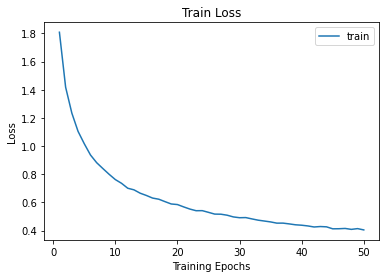

In [ ]:
plt.title('Train Loss')
plt.plot(range(1, Epoch+1), history_s, label='train')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = Model_s(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 77 %


In [ ]:
def knowledge_distillation_loss(logits, labels, teacher_logits):
  
  alpha = 0.1
  T = 5 # 10

  student_loss = F.cross_entropy(input=logits, target=labels)
  # T^2을 곱하는 이유 : 미분시 1/T^2으로 스케일링 됨.
  distillation_loss = nn.KLDivLoss(reduction='batchmean')(F.softmax(logits/T, dim=1).log(), F.softmax(teacher_logits/T, dim=1))*(T*T)
  # distillation_loss = nn.MSELoss()(F.softmax(logits/T, dim=1), F.softmax(teacher_logits/T, dim=1))

  total_loss =  alpha*student_loss + (1-alpha)*distillation_loss

  return total_loss, student_loss, distillation_loss

In [ ]:
def KDModel(s_model, t_model, inputs, labels, model_optimizer, criterion):
  
  model_optimizer.zero_grad()

  loss = 0
  epoch_loss = 0

  # student output
  student_outputs = s_model(inputs)

  # teacher output
  teacher_outputs = t_model(inputs)

  # total loss = student loss + distillation loss
  loss, s_loss, d_loss = criterion(student_outputs, labels, teacher_outputs) 
  loss.backward()
  model_optimizer.step()

  epoch_loss = loss.item()
  stu_loss = s_loss.item()
  distil_loss = d_loss.item()

  return epoch_loss, stu_loss, distil_loss

In [ ]:
def KDTrain(s_model, t_model, train_data, criterion, epoch=1000):

  loss_list = []
  s_loss_list = []
  d_loss_list = []

  optimizer = optim.Adam(s_model.parameters(), lr=0.001)

  # teacher의 경우 학습하지 않으니, eval()로 불러온다.
  s_model.train()   
  t_model.eval()

  for iter in range(epoch):
    loss = 0
    s_loss = 0
    d_loss = 0
    for data in tqdm(train_data):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      t_loss, ss_loss, dd_loss = KDModel(s_model, t_model, inputs, labels, optimizer, criterion)
      loss += t_loss
      s_loss += ss_loss
      d_loss += dd_loss

    if iter%1 == 0:
      print('iteration :%d\ntrain_loss : %.4f student_loss : %.4f distillation_loss : %.4f' % (iter, loss/len(train_data), s_loss/len(train_data), d_loss/len(train_data)))
      loss_list.append(loss/len(train_data))
      s_loss_list.append(s_loss/len(train_data))
      d_loss_list.append(d_loss/len(train_data))

  return s_model, loss_list, s_loss_list, d_loss_list

In [ ]:
# Knowledge_Distillation
student_model = Student_model().to(device)
Model_, history_, history_st, history_d = KDTrain(student_model, t_model, trainloader, knowledge_distillation_loss, epoch=Epoch)

100%|██████████| 391/391 [00:23<00:00, 16.77it/s]


iteration :0
train_loss : 12.4721 student_loss : 2.2944 distillation_loss : 13.6029


100%|██████████| 391/391 [00:23<00:00, 16.64it/s]


iteration :1
train_loss : 8.6010 student_loss : 1.8996 distillation_loss : 9.3456


100%|██████████| 391/391 [00:23<00:00, 16.77it/s]


iteration :2
train_loss : 6.9004 student_loss : 1.6163 distillation_loss : 7.4875


100%|██████████| 391/391 [00:23<00:00, 16.78it/s]


iteration :3
train_loss : 5.8465 student_loss : 1.4299 distillation_loss : 6.3373


100%|██████████| 391/391 [00:23<00:00, 16.68it/s]


iteration :4
train_loss : 5.1791 student_loss : 1.2842 distillation_loss : 5.6119


100%|██████████| 391/391 [00:23<00:00, 16.31it/s]


iteration :5
train_loss : 4.6875 student_loss : 1.1771 distillation_loss : 5.0775


100%|██████████| 391/391 [00:23<00:00, 16.76it/s]


iteration :6
train_loss : 4.3167 student_loss : 1.0871 distillation_loss : 4.6755


100%|██████████| 391/391 [00:23<00:00, 16.85it/s]


iteration :7
train_loss : 4.0676 student_loss : 1.0121 distillation_loss : 4.4071


100%|██████████| 391/391 [00:23<00:00, 16.78it/s]


iteration :8
train_loss : 3.8291 student_loss : 0.9522 distillation_loss : 4.1488


100%|██████████| 391/391 [00:23<00:00, 16.78it/s]


iteration :9
train_loss : 3.6779 student_loss : 0.9177 distillation_loss : 3.9845


100%|██████████| 391/391 [00:23<00:00, 16.75it/s]


iteration :10
train_loss : 3.5597 student_loss : 0.8859 distillation_loss : 3.8568


100%|██████████| 391/391 [00:24<00:00, 16.15it/s]


iteration :11
train_loss : 3.4360 student_loss : 0.8540 distillation_loss : 3.7229


100%|██████████| 391/391 [00:23<00:00, 16.70it/s]


iteration :12
train_loss : 3.3224 student_loss : 0.8133 distillation_loss : 3.6012


100%|██████████| 391/391 [00:23<00:00, 16.80it/s]


iteration :13
train_loss : 3.2250 student_loss : 0.7940 distillation_loss : 3.4951


100%|██████████| 391/391 [00:23<00:00, 16.74it/s]


iteration :14
train_loss : 3.1807 student_loss : 0.7785 distillation_loss : 3.4476


100%|██████████| 391/391 [00:23<00:00, 16.66it/s]


iteration :15
train_loss : 3.1420 student_loss : 0.7664 distillation_loss : 3.4059


100%|██████████| 391/391 [00:24<00:00, 16.25it/s]


iteration :16
train_loss : 3.0888 student_loss : 0.7494 distillation_loss : 3.3488


100%|██████████| 391/391 [00:23<00:00, 16.65it/s]


iteration :17
train_loss : 3.0379 student_loss : 0.7368 distillation_loss : 3.2936


100%|██████████| 391/391 [00:23<00:00, 16.65it/s]


iteration :18
train_loss : 2.9879 student_loss : 0.7175 distillation_loss : 3.2402


100%|██████████| 391/391 [00:23<00:00, 16.61it/s]


iteration :19
train_loss : 2.9266 student_loss : 0.7022 distillation_loss : 3.1738


100%|██████████| 391/391 [00:23<00:00, 16.60it/s]


iteration :20
train_loss : 2.9248 student_loss : 0.7042 distillation_loss : 3.1716


100%|██████████| 391/391 [00:23<00:00, 16.60it/s]


iteration :21
train_loss : 2.8772 student_loss : 0.6850 distillation_loss : 3.1208


100%|██████████| 391/391 [00:23<00:00, 16.35it/s]


iteration :22
train_loss : 2.8392 student_loss : 0.6735 distillation_loss : 3.0798


100%|██████████| 391/391 [00:23<00:00, 16.76it/s]


iteration :23
train_loss : 2.8403 student_loss : 0.6733 distillation_loss : 3.0811


100%|██████████| 391/391 [00:23<00:00, 16.67it/s]


iteration :24
train_loss : 2.7855 student_loss : 0.6611 distillation_loss : 3.0216


100%|██████████| 391/391 [00:23<00:00, 16.67it/s]


iteration :25
train_loss : 2.7814 student_loss : 0.6665 distillation_loss : 3.0164


100%|██████████| 391/391 [00:23<00:00, 16.67it/s]


iteration :26
train_loss : 2.7358 student_loss : 0.6502 distillation_loss : 2.9675


100%|██████████| 391/391 [00:23<00:00, 16.76it/s]


iteration :27
train_loss : 2.7036 student_loss : 0.6370 distillation_loss : 2.9332


100%|██████████| 391/391 [00:23<00:00, 16.35it/s]


iteration :28
train_loss : 2.7172 student_loss : 0.6395 distillation_loss : 2.9481


100%|██████████| 391/391 [00:23<00:00, 16.67it/s]


iteration :29
train_loss : 2.6715 student_loss : 0.6270 distillation_loss : 2.8987


100%|██████████| 391/391 [00:23<00:00, 16.67it/s]


iteration :30
train_loss : 2.6607 student_loss : 0.6248 distillation_loss : 2.8870


100%|██████████| 391/391 [00:23<00:00, 16.66it/s]


iteration :31
train_loss : 2.6454 student_loss : 0.6167 distillation_loss : 2.8708


100%|██████████| 391/391 [00:23<00:00, 16.65it/s]


iteration :32
train_loss : 2.6287 student_loss : 0.6106 distillation_loss : 2.8529


100%|██████████| 391/391 [00:23<00:00, 16.78it/s]


iteration :33
train_loss : 2.6134 student_loss : 0.6101 distillation_loss : 2.8360


100%|██████████| 391/391 [00:23<00:00, 16.38it/s]


iteration :34
train_loss : 2.6251 student_loss : 0.6062 distillation_loss : 2.8495


100%|██████████| 391/391 [00:23<00:00, 16.67it/s]


iteration :35
train_loss : 2.6049 student_loss : 0.6026 distillation_loss : 2.8274


100%|██████████| 391/391 [00:24<00:00, 15.88it/s]


iteration :36
train_loss : 2.5759 student_loss : 0.5920 distillation_loss : 2.7963


100%|██████████| 391/391 [00:23<00:00, 16.73it/s]


iteration :37
train_loss : 2.5659 student_loss : 0.5889 distillation_loss : 2.7856


100%|██████████| 391/391 [00:23<00:00, 16.62it/s]


iteration :38
train_loss : 2.5520 student_loss : 0.5866 distillation_loss : 2.7704


100%|██████████| 391/391 [00:23<00:00, 16.68it/s]


iteration :39
train_loss : 2.5399 student_loss : 0.5834 distillation_loss : 2.7573


100%|██████████| 391/391 [00:23<00:00, 16.46it/s]


iteration :40
train_loss : 2.5242 student_loss : 0.5764 distillation_loss : 2.7406


100%|██████████| 391/391 [00:23<00:00, 16.81it/s]


iteration :41
train_loss : 2.5475 student_loss : 0.5806 distillation_loss : 2.7661


100%|██████████| 391/391 [00:23<00:00, 16.70it/s]


iteration :42
train_loss : 2.5250 student_loss : 0.5707 distillation_loss : 2.7421


100%|██████████| 391/391 [00:23<00:00, 16.68it/s]


iteration :43
train_loss : 2.5148 student_loss : 0.5713 distillation_loss : 2.7307


100%|██████████| 391/391 [00:23<00:00, 16.64it/s]


iteration :44
train_loss : 2.5215 student_loss : 0.5697 distillation_loss : 2.7384


100%|██████████| 391/391 [00:23<00:00, 16.54it/s]


iteration :45
train_loss : 2.4759 student_loss : 0.5564 distillation_loss : 2.6892


100%|██████████| 391/391 [00:23<00:00, 16.44it/s]


iteration :46
train_loss : 2.4930 student_loss : 0.5620 distillation_loss : 2.7075


100%|██████████| 391/391 [00:23<00:00, 16.80it/s]


iteration :47
train_loss : 2.4729 student_loss : 0.5558 distillation_loss : 2.6859


100%|██████████| 391/391 [00:23<00:00, 16.79it/s]


iteration :48
train_loss : 2.4857 student_loss : 0.5549 distillation_loss : 2.7002


100%|██████████| 391/391 [00:23<00:00, 16.67it/s]

iteration :49
train_loss : 2.4949 student_loss : 0.5583 distillation_loss : 2.7101


In [ ]:
# 학습한 모델 저장
PATH = 'drive/MyDrive/Implementation/'
torch.save(Model_.state_dict(), PATH+'s_model_state_dict.pt') # 파라미터만 저장
torch.save(Model_, PATH +'s_model.pt') # 전체 모델 저장

In [ ]:
s_model = torch.load(PATH +'s_model.pt') # , map_location=device
s_model.eval()

Student_model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
img = img.to(device)
outputs = s_model(img)
_, predicted = torch.max(outputs,1)
print('Predicted:', ' '.join('%s' % classes[predicted[j]] for j in range(4)))

Predicted: cat ship ship plane


In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = s_model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 80 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = s_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 81 %
Accuracy of   car : 90 %
Accuracy of  bird : 69 %
Accuracy of   cat : 75 %
Accuracy of  deer : 83 %
Accuracy of   dog : 63 %
Accuracy of  frog : 86 %
Accuracy of horse : 80 %
Accuracy of  ship : 88 %
Accuracy of truck : 85 %


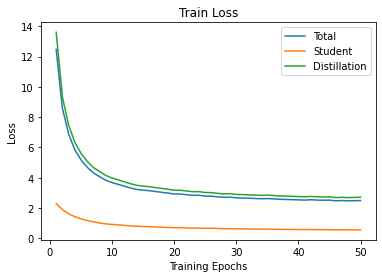

In [ ]:
plt.title('Train Loss')
plt.plot(range(1, Epoch+1), history_, label='Total')
plt.plot(range(1, Epoch+1), history_st, label='Student')
plt.plot(range(1, Epoch+1), history_d, label='Distillation')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()